### WEIGHT DEVELOPMENT WILCOXON SIGNED-RANK TEST

In this Notebook, Wilcoxon Signed-Rank Test is performed on the weight and bias development over time for the two models. This is done in a total of six developments over checkpoints 1->2, 1->3, 1->4, 2->3, 2->4, and 3->4.

##### LOADING NECESSARY LIBRARIES AND CREATING NECESSARY FUNCTIONS

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import custom_vgg22
import preloaded_vgg22
import os
import matplotlib.patches as mpatches

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
# function to load preloaded VGGNet model on custom VGGNet model architecture
def model_preload(weights=tf.keras.Model.weights):
    """
    input:
    weights -- weights of the base VGGNet model

    output:
    tf.keras.Model -- VGG22 Model with preloaded_VGG weights but custom_VGG architecture
    
    """
    # purpose of this function is to make later weights and biases comparisons easier
    # by providing the same architecture to both the models
    
    base_model = preloaded_vgg22.cifar10_VGG22()   # loading preloaded VGG22 model
    base_model.load_weights(weights)
    
    preload_model = custom_vgg22.cifar10_custom_VGG22()  # loading custom VGG22 model

    i = 2
    # assigning weights correspondingly from preloaded model to custom model
    for layer in base_model.layers[3].layers:
        preload_model.layers[i].set_weights(layer.weights)  # VGGNet architecture
        i += 1
    
    preload_model.layers[i].set_weights(base_model.layers[4].weights)       # batchnormalization layer
    preload_model.layers[i+3].set_weights(base_model.layers[7].weights)     # fc1 dense layer
    preload_model.layers[i+5].set_weights(base_model.layers[9].weights)     # fc2 dense layer
    preload_model.layers[i+7].set_weights(base_model.layers[11].weights)    # fc3 dense layer
    preload_model.layers[i+9].set_weights(base_model.layers[13].weights)    # fc4 dense layer
    preload_model.layers[i+11].set_weights(base_model.layers[15].weights)   # predictions layer

    return preload_model

In [4]:
# function to perform Wilcoxon Signed-Rank Test across the two models for respective layer weight and bias differences
def wilcoxon_calc(preload_models=[tf.keras.Model, tf.keras.Model], custom_models=[tf.keras.Model, tf.keras.Model]):
    """
    input:
    preload_models -- two tf.keras.Model
    custom_models -- two tf.keras.Model

    output:
    dictionary -- a dictionary with Wilcoxon Signed-Rank Test results
    """
    data = {}

    for i in range(len(preload_models[0].layers)):  # looping through the model     
        if preload_models[0].layers[i].weights != []:  # excluding layers without weights and biases
            # weight difference for the two preload models
            preload_weights_diff = preload_models[1].layers[i].get_weights()[0].flatten() - preload_models[0].layers[i].get_weights()[0].flatten()
            # bias difference for the two preload models
            preload_biases_diff = preload_models[1].layers[i].get_weights()[1] - preload_models[0].layers[i].get_weights()[1]
            # weight difference for the two custom models
            custom_weights_diff = custom_models[1].layers[i].get_weights()[0].flatten() - custom_models[0].layers[i].get_weights()[0].flatten()
            # bias difference for the two custom models
            custom_biases_diff = custom_models[1].layers[i].get_weights()[1] - custom_models[0].layers[i].get_weights()[1]
            # performing Wilcoxon Signed-Rank Test while
            # making sure that neither either vector nor their element-wise subtraction is a zero vector
            if np.all(preload_weights_diff - custom_weights_diff != 0.0) and np.all(preload_weights_diff != 0.0) and np.all(custom_weights_diff != 0.0):
                _, data[preload_models[0].layers[i].name+"_w"] = stats.wilcoxon(preload_weights_diff, custom_weights_diff)
            if np.all(preload_biases_diff - custom_biases_diff != 0.0) and np.all(preload_biases_diff != 0.0) and np.all(custom_biases_diff != 0.0):
                _, data[preload_models[0].layers[i].name+"_b"] = stats.wilcoxon(preload_biases_diff, custom_biases_diff)
            
    return data

In [5]:
# function to transform dictionary to Pandas DataFrame
def dict_to_DF(g_dict=None, checkpoint=None):
    """
    input:
    g_dict -- a dictionary with Wilcoxon Signed-Rank Test results
    checkpoint -- model checkpoint as a string
    
    output:
    Pandas DataFrame -- a Pandas DataFrame
    
    """
    data = pd.DataFrame(list(g_dict.items()), columns=['Layer', 'p-Value'])  # creating DataFrame
    # creating a column to tell if H0 is rejected or not
    data["Median Difference"] = data['p-Value'].apply(lambda x: "Not significant (H0 rejection fail)" if x > 0.05 else "Significant (reject H0)")
    # creating a column with binary encoded median difference values
    data["binary difference"] = data['p-Value'].apply(lambda x: 0 if x > 0.05 else 1)
    # creating a column with checkpoint values
    data["checkpoint"] = checkpoint
    # creating a column to spot weights or biases
    data["value category"] = data["Layer"].apply(lambda x: "Weights" if x.rsplit("_", 1)[-1] == "w" else "Biases")
    # fixing up the Layer column
    data["Layer"] = data["Layer"].apply(lambda x: x.rsplit("_", 1)[0])
    
    return data

### CHECKPOINT 1 TO CHECKPOINT 2 WILCOXON SIGNED-RANK TEST

In [6]:
# loading all the models with respective initial and final weights
custom_models = [custom_vgg22.cifar10_custom_VGG22(weights='D:/CIFAR_10_stuff/weights/custom_VGG_checkpoint_1.h5'),
                 custom_vgg22.cifar10_custom_VGG22(weights='D:/CIFAR_10_stuff/weights/custom_VGG_checkpoint_2.h5')]
preload_models = [model_preload(weights='D:/CIFAR_10_stuff/weights/preload_VGG_checkpoint_1.h5'),
                  model_preload(weights='D:/CIFAR_10_stuff/weights/preload_VGG_checkpoint_2.h5')]

In [7]:
# performing the test across the respective layer weight and bias differences
wilcoxon_data = wilcoxon_calc(preload_models=preload_models, custom_models=custom_models)

In [8]:
# putting together the calculations into a Pandas DataFrame
wilcoxon_df = dict_to_DF(g_dict=wilcoxon_data, checkpoint="Checkpoints: 1 to 2")
wilcoxon_df.iloc[:,:3].head()

,Layer,p-Value,Median Difference
0,batch_norm,4.497109e-77,Significant (reject H0)
1,batch_norm,2.477472e-24,Significant (reject H0)
2,fc1,1.042415e-243,Significant (reject H0)
3,fc1,4.056193e-169,Significant (reject H0)
4,fc2,0.000000e+00,Significant (reject H0)


In [9]:
# putting together a new Pandas DataFrame to combine results from all checkpoints
overall_wilcoxon_data = wilcoxon_df

### CHECKPOINT 1 TO CHECKPOINT 3 WILCOXON SIGNED-RANK TEST

In [10]:
# loading all the models with respective initial and final weights
custom_models = [custom_vgg22.cifar10_custom_VGG22(weights='D:/CIFAR_10_stuff/weights/custom_VGG_checkpoint_1.h5'),
                 custom_vgg22.cifar10_custom_VGG22(weights='D:/CIFAR_10_stuff/weights/custom_VGG_checkpoint_3.h5')]
preload_models = [model_preload(weights='D:/CIFAR_10_stuff/weights/preload_VGG_checkpoint_1.h5'),
                  model_preload(weights='D:/CIFAR_10_stuff/weights/preload_VGG_checkpoint_3.h5')]

In [11]:
# performing the test across the respective layer weight and bias differences
wilcoxon_data = wilcoxon_calc(preload_models=preload_models, custom_models=custom_models)

In [12]:
# putting together the calculations into a Pandas DataFrame
wilcoxon_df = dict_to_DF(g_dict=wilcoxon_data, checkpoint="Checkpoints: 1 to 3")
wilcoxon_df.iloc[:,:3].head()

,Layer,p-Value,Median Difference
0,block1_conv1,7.102209e-01,Not significant (H0 rejection fail)
1,block1_conv1,9.466812e-01,Not significant (H0 rejection fail)
2,block1_conv2,3.840897e-11,Significant (reject H0)
3,block1_conv2,9.626626e-01,Not significant (H0 rejection fail)
4,block2_conv1,6.791331e-03,Significant (reject H0)


In [13]:
# putting checkpoint 1 to checkpoint 3 results into a combined results DataFrame
overall_wilcoxon_data = pd.concat([overall_wilcoxon_data, wilcoxon_df], ignore_index=True)

### CHECKPOINT 1 TO CHECKPOINT 4 WILCOXON SIGNED-RANK TEST

In [14]:
# loading all the models with respective initial and final weights
custom_models = [custom_vgg22.cifar10_custom_VGG22(weights='D:/CIFAR_10_stuff/weights/custom_VGG_checkpoint_1.h5'),
                 custom_vgg22.cifar10_custom_VGG22(weights='D:/CIFAR_10_stuff/weights/custom_VGG_checkpoint_4.h5')]
preload_models = [model_preload(weights='D:/CIFAR_10_stuff/weights/preload_VGG_checkpoint_1.h5'),
                  model_preload(weights='D:/CIFAR_10_stuff/weights/preload_VGG_checkpoint_4.h5')]

In [15]:
# performing the test across the respective layer weight and bias differences
wilcoxon_data = wilcoxon_calc(preload_models=preload_models, custom_models=custom_models)

In [16]:
# putting together the calculations into a Pandas DataFrame
wilcoxon_df = dict_to_DF(g_dict=wilcoxon_data, checkpoint="Checkpoints: 1 to 4")
wilcoxon_df.iloc[:,:3].head()

,Layer,p-Value,Median Difference
0,block1_conv1,0.627072,Not significant (H0 rejection fail)
1,block1_conv1,0.688236,Not significant (H0 rejection fail)
2,block1_conv2,0.000002,Significant (reject H0)
3,block1_conv2,0.867222,Not significant (H0 rejection fail)
4,block2_conv1,0.051054,Not significant (H0 rejection fail)


In [17]:
# putting checkpoint 1 to checkpoint 4 results into a combined results DataFrame
overall_wilcoxon_data = pd.concat([overall_wilcoxon_data, wilcoxon_df], ignore_index=True)

### CHECKPOINT 2 TO CHECKPOINT 3 WILCOXON SIGNED-RANK TEST

In [18]:
# loading all the models with respective initial and final weights
custom_models = [custom_vgg22.cifar10_custom_VGG22(weights='D:/CIFAR_10_stuff/weights/custom_VGG_checkpoint_2.h5'),
                 custom_vgg22.cifar10_custom_VGG22(weights='D:/CIFAR_10_stuff/weights/custom_VGG_checkpoint_3.h5')]
preload_models = [model_preload(weights='D:/CIFAR_10_stuff/weights/preload_VGG_checkpoint_2.h5'),
                  model_preload(weights='D:/CIFAR_10_stuff/weights/preload_VGG_checkpoint_3.h5')]

In [19]:
# performing the test across the respective layer weight and bias differences
wilcoxon_data = wilcoxon_calc(preload_models=preload_models, custom_models=custom_models)

In [20]:
# putting together the calculations into a Pandas DataFrame
wilcoxon_df = dict_to_DF(g_dict=wilcoxon_data, checkpoint="Checkpoints: 2 to 3")
wilcoxon_df.iloc[:,:3].head()

,Layer,p-Value,Median Difference
0,block1_conv1,7.842479e-11,Significant (reject H0)
1,block1_conv1,4.245792e-04,Significant (reject H0)
2,block1_conv2,0.000000e+00,Significant (reject H0)
3,block1_conv2,9.466812e-01,Not significant (H0 rejection fail)
4,block2_conv1,0.000000e+00,Significant (reject H0)


In [21]:
# putting checkpoint 2 to checkpoint 3 results into a combined results DataFrame
overall_wilcoxon_data = pd.concat([overall_wilcoxon_data, wilcoxon_df], ignore_index=True)

### CHECKPOINT 2 TO CHECKPOINT 4 WILCOXON SIGNED-RANK TEST

In [22]:
# loading all the models with respective initial and final weights
custom_models = [custom_vgg22.cifar10_custom_VGG22(weights='D:/CIFAR_10_stuff/weights/custom_VGG_checkpoint_2.h5'),
                 custom_vgg22.cifar10_custom_VGG22(weights='D:/CIFAR_10_stuff/weights/custom_VGG_checkpoint_4.h5')]
preload_models = [model_preload(weights='D:/CIFAR_10_stuff/weights/preload_VGG_checkpoint_2.h5'),
                  model_preload(weights='D:/CIFAR_10_stuff/weights/preload_VGG_checkpoint_4.h5')]

In [23]:
# performing the test across the respective layer weight and bias differences
wilcoxon_data = wilcoxon_calc(preload_models=preload_models, custom_models=custom_models)

In [24]:
# putting together the calculations into a Pandas DataFrame
wilcoxon_df = dict_to_DF(g_dict=wilcoxon_data, checkpoint="Checkpoints: 2 to 4")
wilcoxon_df.iloc[:,:3].head()

,Layer,p-Value,Median Difference
0,block1_conv1,0.009329,Significant (reject H0)
1,block1_conv1,0.000162,Significant (reject H0)
2,block1_conv2,0.000000,Significant (reject H0)
3,block1_conv2,0.957334,Not significant (H0 rejection fail)
4,block2_conv1,0.000000,Significant (reject H0)


In [25]:
# putting checkpoint 2 to checkpoint 4 results into a combined results DataFrame
overall_wilcoxon_data = pd.concat([overall_wilcoxon_data, wilcoxon_df], ignore_index=True)

### CHECKPOINT 3 TO CHECKPOINT 4 WILCOXON SIGNED-RANK TEST

In [26]:
# loading all the models with respective initial and final weights
custom_models = [custom_vgg22.cifar10_custom_VGG22(weights='D:/CIFAR_10_stuff/weights/custom_VGG_checkpoint_3.h5'),
                 custom_vgg22.cifar10_custom_VGG22(weights='D:/CIFAR_10_stuff/weights/custom_VGG_checkpoint_4.h5')]
preload_models = [model_preload(weights='D:/CIFAR_10_stuff/weights/preload_VGG_checkpoint_3.h5'),
                  model_preload(weights='D:/CIFAR_10_stuff/weights/preload_VGG_checkpoint_4.h5')]

In [27]:
# performing the test across the respective layer weight and bias differences
wilcoxon_data = wilcoxon_calc(preload_models=preload_models, custom_models=custom_models)

In [28]:
# putting together the calculations into a Pandas DataFrame
wilcoxon_df = dict_to_DF(g_dict=wilcoxon_data, checkpoint="Checkpoints: 3 to 4")
wilcoxon_df.iloc[:,:3].head()

,Layer,p-Value,Median Difference
0,block1_conv1,6.656317e-09,Significant (reject H0)
1,block1_conv1,3.208246e-04,Significant (reject H0)
2,block1_conv2,0.000000e+00,Significant (reject H0)
3,block1_conv2,8.567109e-01,Not significant (H0 rejection fail)
4,block2_conv1,7.274342e-73,Significant (reject H0)


In [29]:
# putting checkpoint 3 to checkpoint 4 results into a combined results DataFrame
overall_wilcoxon_data = pd.concat([overall_wilcoxon_data, wilcoxon_df], ignore_index=True)

### TEST RESULTS VISULAIZATION

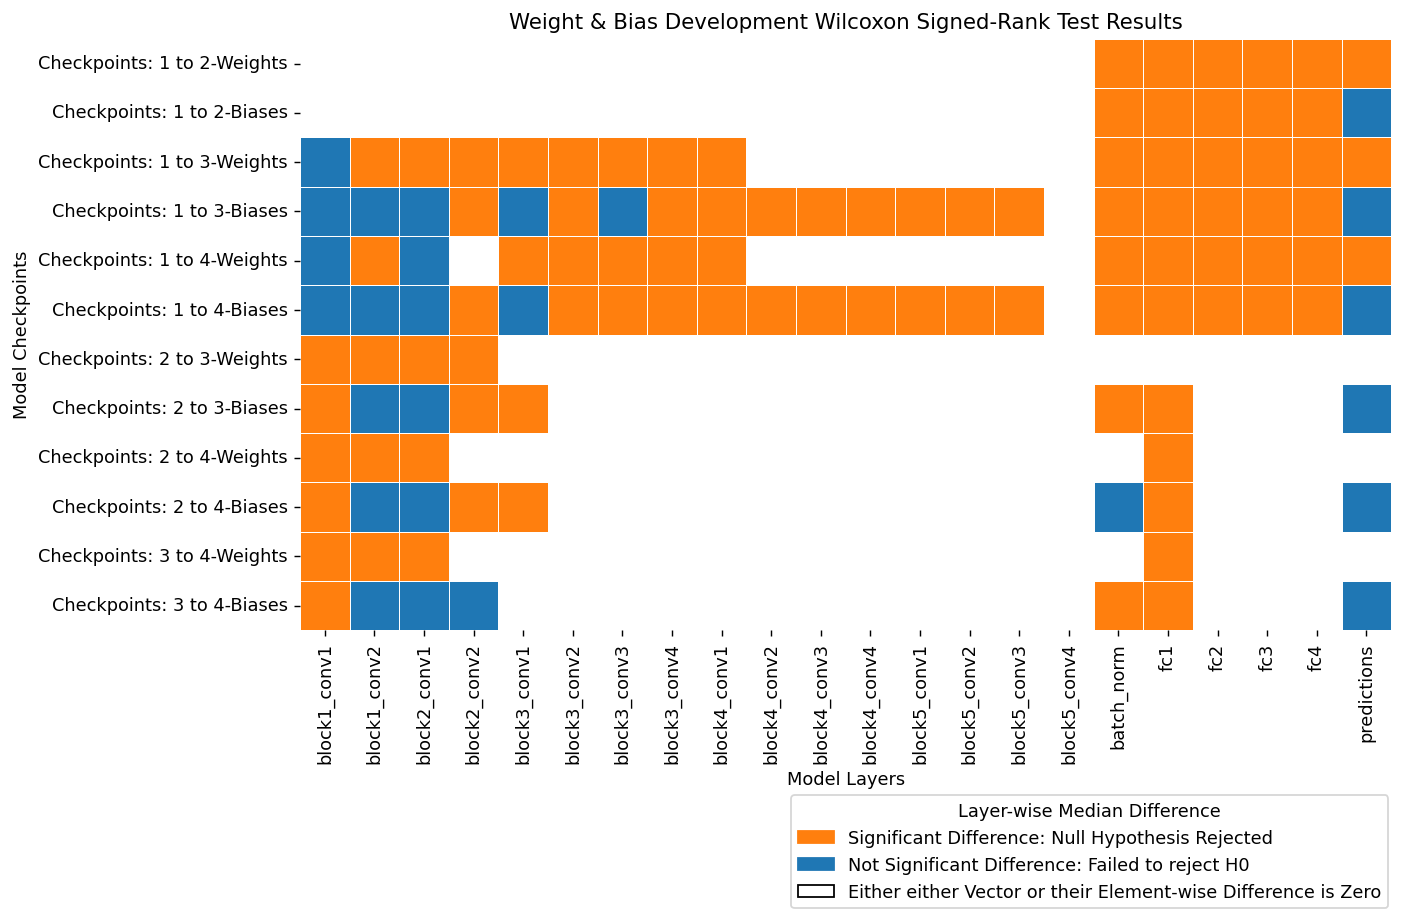

In [30]:
# Wilcoxon Signed-Rank Test Results Data Visualization
data = overall_wilcoxon_data.pivot(index="Layer", columns=["checkpoint", "value category"], values="binary difference")
layers = [layer.name for layer in custom_models[0].layers if layer.weights != []]  # getting names of the layers for proper indexing
data = data.reindex(layers)

plt.figure(figsize=(11, 6), dpi=128)

sns.heatmap(data.T, cbar=False, cmap=sns.color_palette(n_colors=2), linewidths=0.5)

significant_patch = mpatches.Patch(color=sns.color_palette(as_cmap=True)[1], label='Significant Difference: Null Hypothesis Rejected')
not_significant_patch = mpatches.Patch(color=sns.color_palette(as_cmap=True)[0], label='Not Significant Difference: Failed to reject H0')
missing_data_patch = mpatches.Patch(facecolor="white", edgecolor="black", label="Either either Vector or their Element-wise Difference is Zero")
plt.legend(handles=[significant_patch, not_significant_patch, missing_data_patch], loc=(0.45,-0.47), title='Layer-wise Median Difference')

plt.xlabel('Model Layers')
plt.ylabel('Model Checkpoints')
plt.title('Weight & Bias Development Wilcoxon Signed-Rank Test Results')

plt.show()